In [1]:
import sys, os
import numpy as np
from scipy.optimize import minimize

import matplotlib, matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 
### load the emulator

In [2]:
sys.path.append("../")
from csstlab import Emulator, EFTofLSS_Model
%time emu = Emulator()

CPU times: user 10.1 ms, sys: 37 ms, total: 47.1 ms
Wall time: 47.1 ms


### 
### generate the basis spectra given cosmology

In [3]:
# 8 cosmological paramters : 
#    Omega_b, Omega_m, h, n_s, 1e9 A_s, w_0, w_a, M_\nu 
params = [ 0.048, 0.31, 0.67, 0.9665, 2.105, -0.9, 0.1, 0.03, ]

## default (k, z)-bins
emu.unset_k_and_z()    ## recover the output (k, z)-bins as default
k1 = emu.k
z1 = emu.z
%time Pk_ij_1 = emu(params)

## set the (k, z)-bins
## notice that more time is required for interpolation
k2 = np.logspace(-3, 0, 200)
z2 = emu.z
emu.set_k_and_z(k2, z2)
%time Pk_ij_2 = emu(params)

print( k1.shape, k2.shape, Pk_ij_1.shape, Pk_ij_2.shape )

CPU times: user 46.7 ms, sys: 90.7 ms, total: 137 ms
Wall time: 25.8 ms
CPU times: user 274 ms, sys: 406 ms, total: 680 ms
Wall time: 92.6 ms
(45,) (200,) (21, 12, 45) (21, 12, 200)


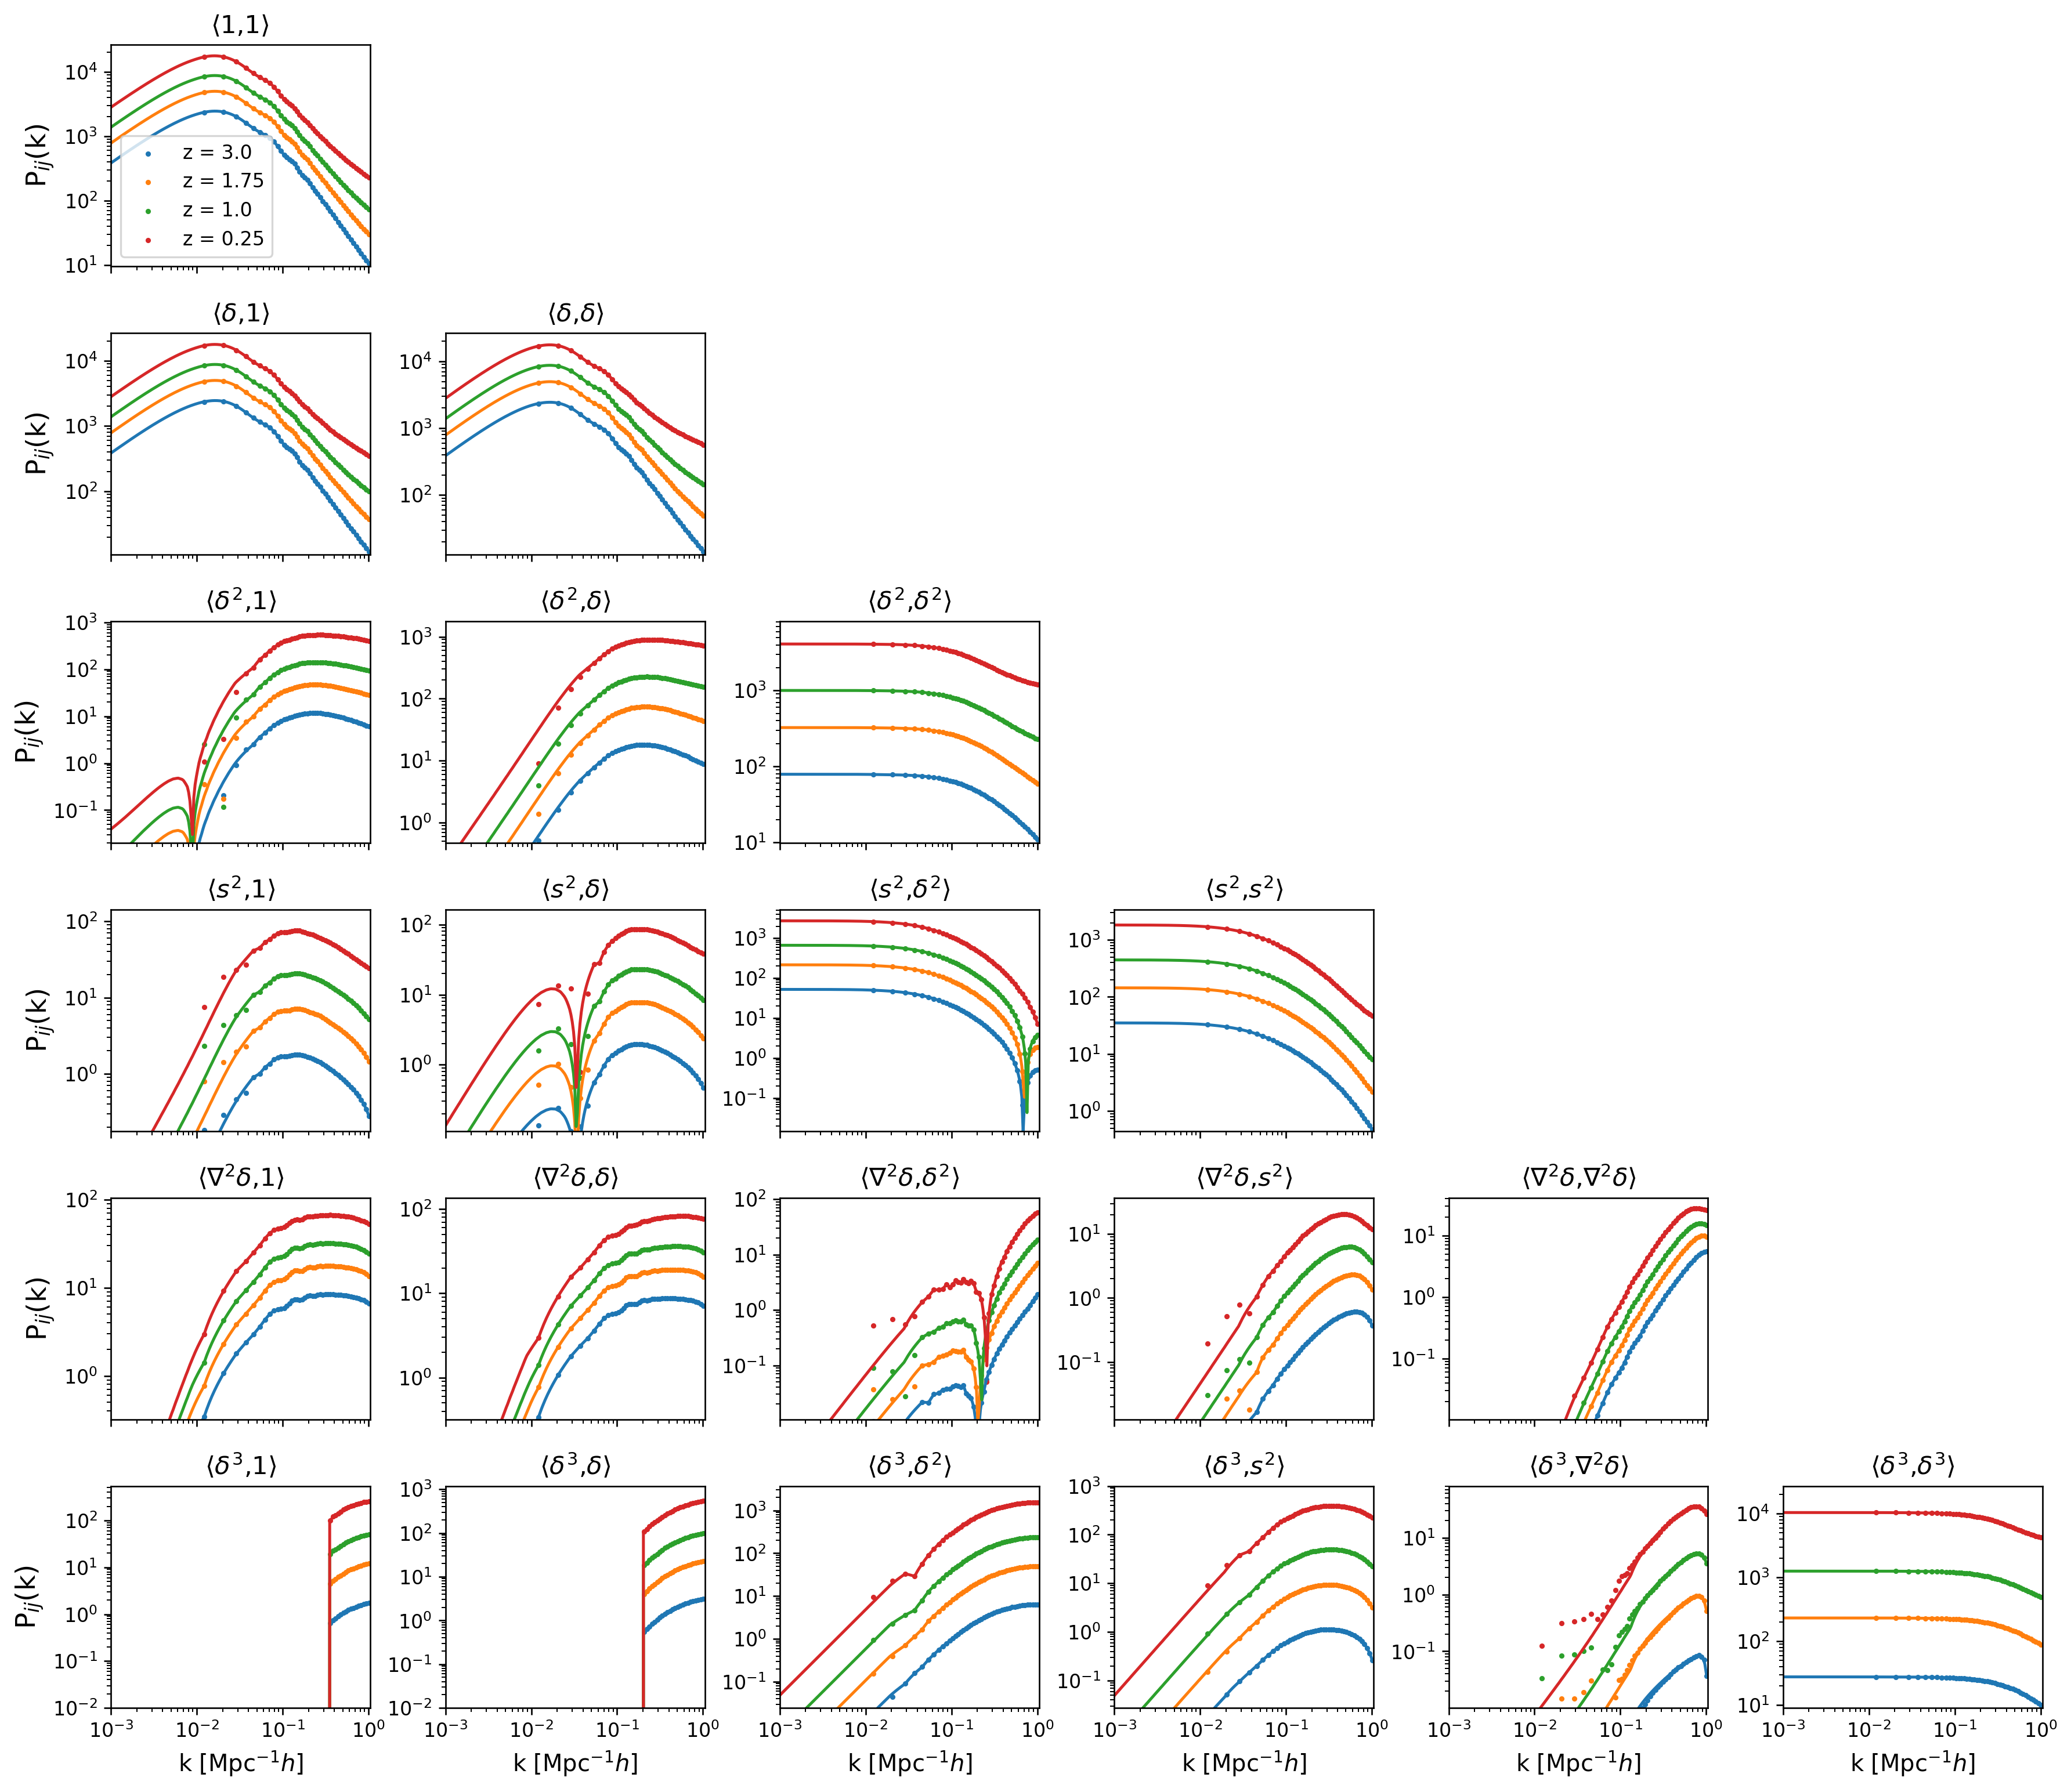

In [4]:
labels = [
    "1", 
    r"$\delta$", 
    r"$\delta^2$", 
    r"$s^2$", 
    r"$\nabla^2\delta$", 
    r"$\delta^3$", 
]

iz = 0
n = 6
fig, axes = plt.subplots(n, n, dpi=120, figsize=(15, 13), sharex=True, )
ipk = -1
for j in range(n):
    for i in range(n):
        if i < j: axes[i,j].axis('off') ; continue
        ipk += 1
        for iz in range(0, 12, 3):
            axes[i,j].scatter( k1, np.abs(Pk_ij_1[ipk, iz,]), s=3, c=f"C{iz//3}", label=f"z = {z1[iz]}" )
            axes[i,j].loglog( k2, np.abs(Pk_ij_2[ipk, iz,]), c=f"C{iz//3}", )
        
        vmin, vmax = np.abs(Pk_ij_1[ipk]).min(), np.abs(Pk_ij_1[ipk]).max()
        axes[i,j].set_title( f'⟨{labels[i]},{labels[j]}⟩', fontsize=13)
        axes[i,j].set_xlim( 1e-3, 1.05 )
        axes[i,j].set_ylim( vmin*0.9+1e-2, vmax*1.2 )
for i in range(n):
    axes[-1,i].set_xlabel(r"k [Mpc$^{-1}h$]", fontsize=12, )
    axes[i, 0].set_ylabel("P$_{ij}$(k)", fontsize=14, )
axes[0,0].legend(fontsize=10)
plt.tight_layout( h_pad=0.8, w_pad=0, )
plt.show()

### 
### load the halo auto & halo-matter cross power spectra

In [5]:
def GaussianCovariance( pk_hh, pk_hm, pk_mm, Nk, ):
    hhhh = np.diag(pk_hh**2 /Nk)
    hhhm = np.diag(pk_hh*pk_hm /Nk)
    hhmm = np.diag(pk_hh*pk_mm /Nk)
    hmhm = np.diag(pk_hm**2 /Nk)
    return np.vstack([
            np.hstack([ 2*hhhh , 2*hhhm     , ]), 
            np.hstack([ 2*hhhm , hhmm + hmhm, ]), 
        ])
    
haloSpec = np.load( "Halo_PowerSpectrum.npy",  allow_pickle=True, )[()]

L = 1000
dV_k = (2*np.pi/L)**3
kedges = haloSpec["c0000"]["k_edges"]
dk = kedges[1:] - kedges[:-1]
k = 0.5*(kedges[1:]+kedges[:-1])
z = emu.z    # redshift of halo samples is same as the default emulation redshift
Massbin_edges = [11, 11.5, 12.0, 12.5, 13.0, 14.0]
Nk_cells = 4*np.pi *dk *k**2 /dV_k /2.

print( haloSpec["CosmoParam"]['label-param'] )
print( "\n", "i.e. Cosmologcial parameters of simualtion " + 
      haloSpec["CosmoParam"]["label-simu"][1] + " :  \n\t" ,
      haloSpec["CosmoParam"]["values"][1] )

print( "\nredshift, halo-mass, k-bins  :  ", haloSpec["c0083"]["Pk_hh"].shape )
print( "redshift, halo-mass, k-bins  :  ", haloSpec["c0083"]["Pk_hm"].shape )
print( "redshift, k-bins  :  ", haloSpec["c0083"]["Pk_mm"].shape )

['$\\Omega_b$', '$\\Omega_m$', '$h$', '$n_s$', '$A_s\\times10^9$', '$w$', '$w_a$', '$M_{\\nu}$']

 i.e. Cosmologcial parameters of simualtion c0083 :  
	 [ 0.05734375  0.29875     0.7828125   0.939375    1.84375    -1.1265625
 -0.1171875   0.05390625]

redshift, halo-mass, k-bins  :   (12, 5, 48)
redshift, halo-mass, k-bins  :   (12, 5, 48)
redshift, k-bins  :   (12, 48)


### 
### joint fit the halo auto-&cross spectrum to get the bias parameters

In [6]:
bin_z = 6     # index of redshift bin
bin_m = 2     # index of halo mass bin
k_max = 0.7   # maximum fitting k scale; unit : [h/Mpc]

indk = k < k_max
pk_hh = haloSpec["c0083"]["Pk_hh"][bin_z, bin_m]
pk_hm = haloSpec["c0083"]["Pk_hm"][bin_z, bin_m]
pk_mm = haloSpec["c0083"]["Pk_mm"][bin_z]
nhalo = haloSpec["c0083"]["Nhalo"][bin_z, bin_m]

cosmoParam = haloSpec["CosmoParam"]["values"][1]
emu.set_k_and_z(k[indk], [ z[bin_z] ] )
pkij_list = emu( cosmoParam )
pk_shot = L**3 /nhalo

pk_stack = np.hstack([pk_hh[indk], pk_hm[indk]])

cov_hhhh = GaussianCovariance( pk_hh[indk], pk_hm[indk], pk_hm[indk], Nk_cells[indk], )
vals, vecs = np.linalg.eigh(cov_hhhh)
vals_inv = 1/vals
vals_inv[ vals < vals.max()*1e-15 ] = 0      ## also remove negative eigenvalues
cov_inv = vecs @ np.diag(vals_inv) @ vecs.T 


def LossFunc(bias):
    alpha, bs = bias[:1], bias[1:]
    pk_auto, pk_cross = EFTofLSS_Model.CombinePkij( k[indk], pkij_list, *bs )
    pk_auto += alpha[0] *pk_shot  # shot noise

    pk_delta = pk_stack - np.hstack([pk_auto, pk_cross,])
    val = pk_delta @ cov_inv @ pk_delta
    return val


mout = minimize( LossFunc, x0 = [1, ]*5, 
            method="Powell", tol=1e-10, 
            options={"maxiter":20000}, 
            )
bias = mout["x"]

print( "best-fit bias parameters : \n\t alpha, b_1, b_2, b_s, b_nabla" )
print( "\t", bias )
print( mout["success"] )

best-fit bias parameters : 
	 alpha, b_1, b_2, b_s, b_nabla
	 [ 1.03550551  0.31864495 -0.43218738 -0.14306835 -0.14009106]
True


The wavenumber `k` is out of the range of the emulator (0.001 < k < 1.05 h/Mpc). 
Note that for those k < 0.001 or k > 1.05, the emulator will be extrapolated. 


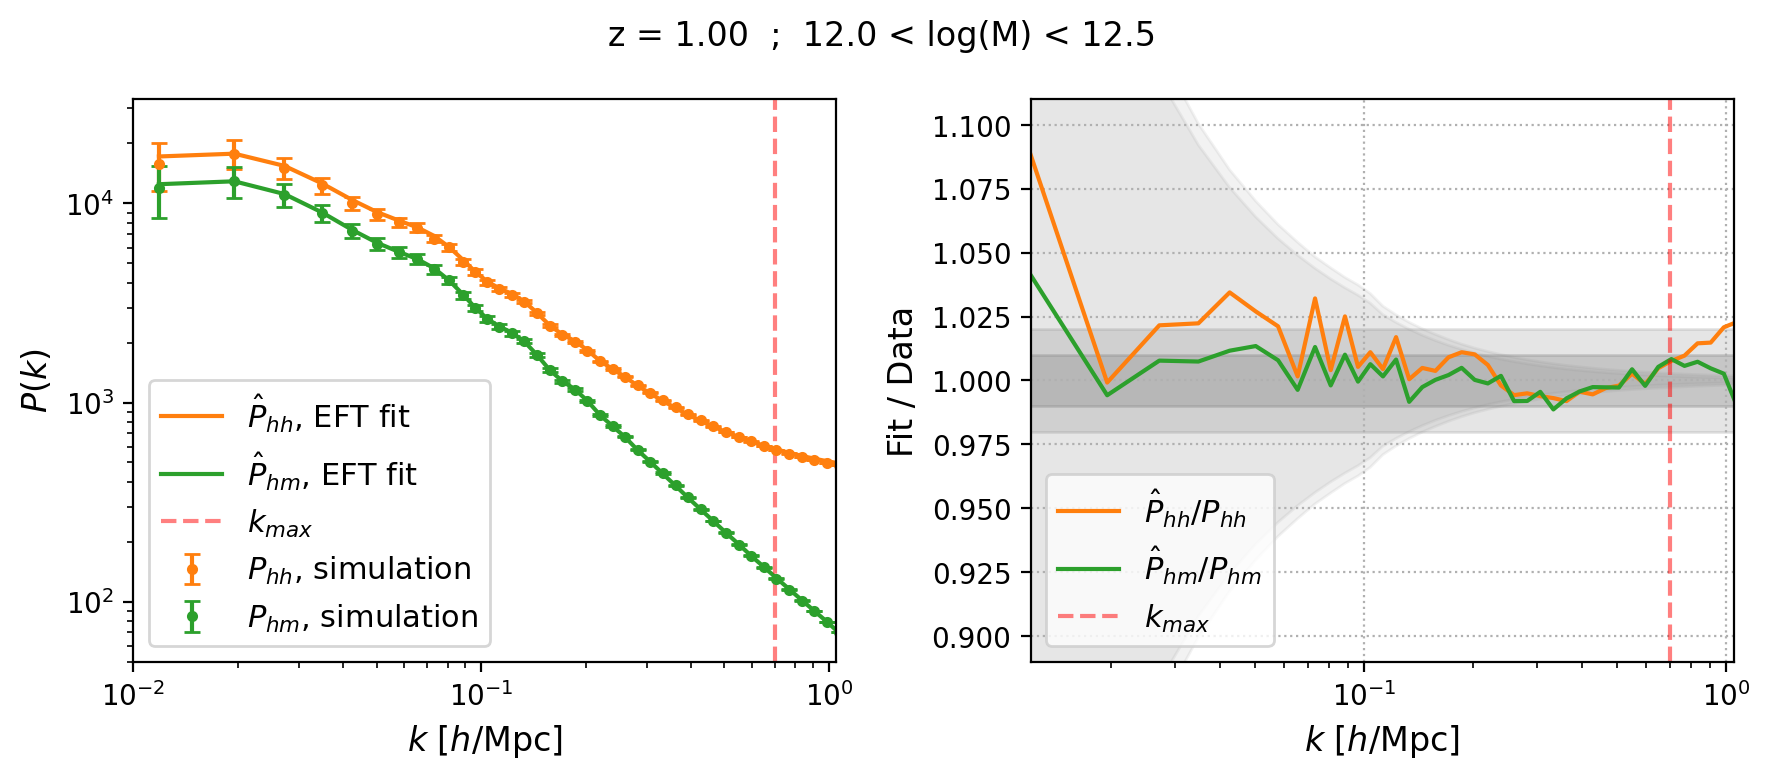

In [7]:
emu.set_k_and_z(k, [ z[bin_z] ] )
pkij_list = emu(cosmoParam)
pk_auto, pk_cross = EFTofLSS_Model.CombinePkij( k, pkij_list, *bias[1:] )
pk_auto += bias[0] *pk_shot

cov_hhhh = GaussianCovariance( pk_hh, pk_hm, pk_hm, Nk_cells, )
std_hh, std_hm = np.sqrt(cov_hhhh.diagonal()).reshape(2, -1)

fig, axes = plt.subplots(1, 2, figsize=(9, 4) )
axes[0].loglog( k, pk_auto , c="C1", label=r"$\hat{P}_{hh}$, EFT fit", )
axes[0].errorbar( k, pk_hh, yerr=std_hh, capsize=3, c="C1", ls='', marker='.', label=r"$P_{hh}$, simulation", )
axes[0].loglog( k, pk_cross , c="C2", label=r"$\hat{P}_{hm}$, EFT fit", )
axes[0].errorbar( k, pk_hm, yerr=std_hm, capsize=3, c="C2", ls='', marker='.', label=r"$P_{hm}$, simulation", )

axes[1].fill_between( k, std_hh/pk_hh +1, -std_hh/pk_hh +1, color='gray', alpha=0.1)
axes[1].fill_between( k, std_hm/pk_hm +1, -std_hm/pk_hm +1, color='gray', alpha=0.1)
arrone = np.ones(k.shape)
axes[1].fill_between( k, 0.99 *arrone, 1.01 *arrone , color='gray', alpha=0.3, zorder=-100, )
axes[1].fill_between( k, 0.98 *arrone, 1.02 *arrone , color='gray', alpha=0.2, zorder=-100, )
axes[1].plot( k, pk_auto /pk_hh , c="C1", label=r"$\hat{P}_{hh} /{P}_{hh} $" )
axes[1].plot( k, pk_cross/pk_hm , c="C2", label=r"$\hat{P}_{hm} /{P}_{hm} $" )

axes[1].grid(True, ls=':')
axes[1].set_xscale("log")
for i in range(2):
    axes[i].axvline( k_max, c='r', alpha=0.5, ls='--', label='$k_{max}$', )
    axes[i].legend( loc='lower left', fontsize=11, )
    axes[i].set_xlabel("$k$ [$h$/Mpc]", fontsize=12 )
axes[0].set_xlim( 0.010,  1.05, )
axes[1].set_xlim( 0.012,  1.05, )
axes[0].set_ylim( 50 )
axes[1].set_ylim( 0.89,  1.11, )
axes[0].set_ylabel("$P(k)$", fontsize=12 )
axes[1].set_ylabel("Fit / Data", fontsize=12 )
plt.suptitle( "z = %1.2f  ;  %1.1f < log(M) < %1.1f"%(z[bin_z], Massbin_edges[bin_m], Massbin_edges[bin_m+1]) , fontsize=12, )
plt.tight_layout()
plt.show()

### README example

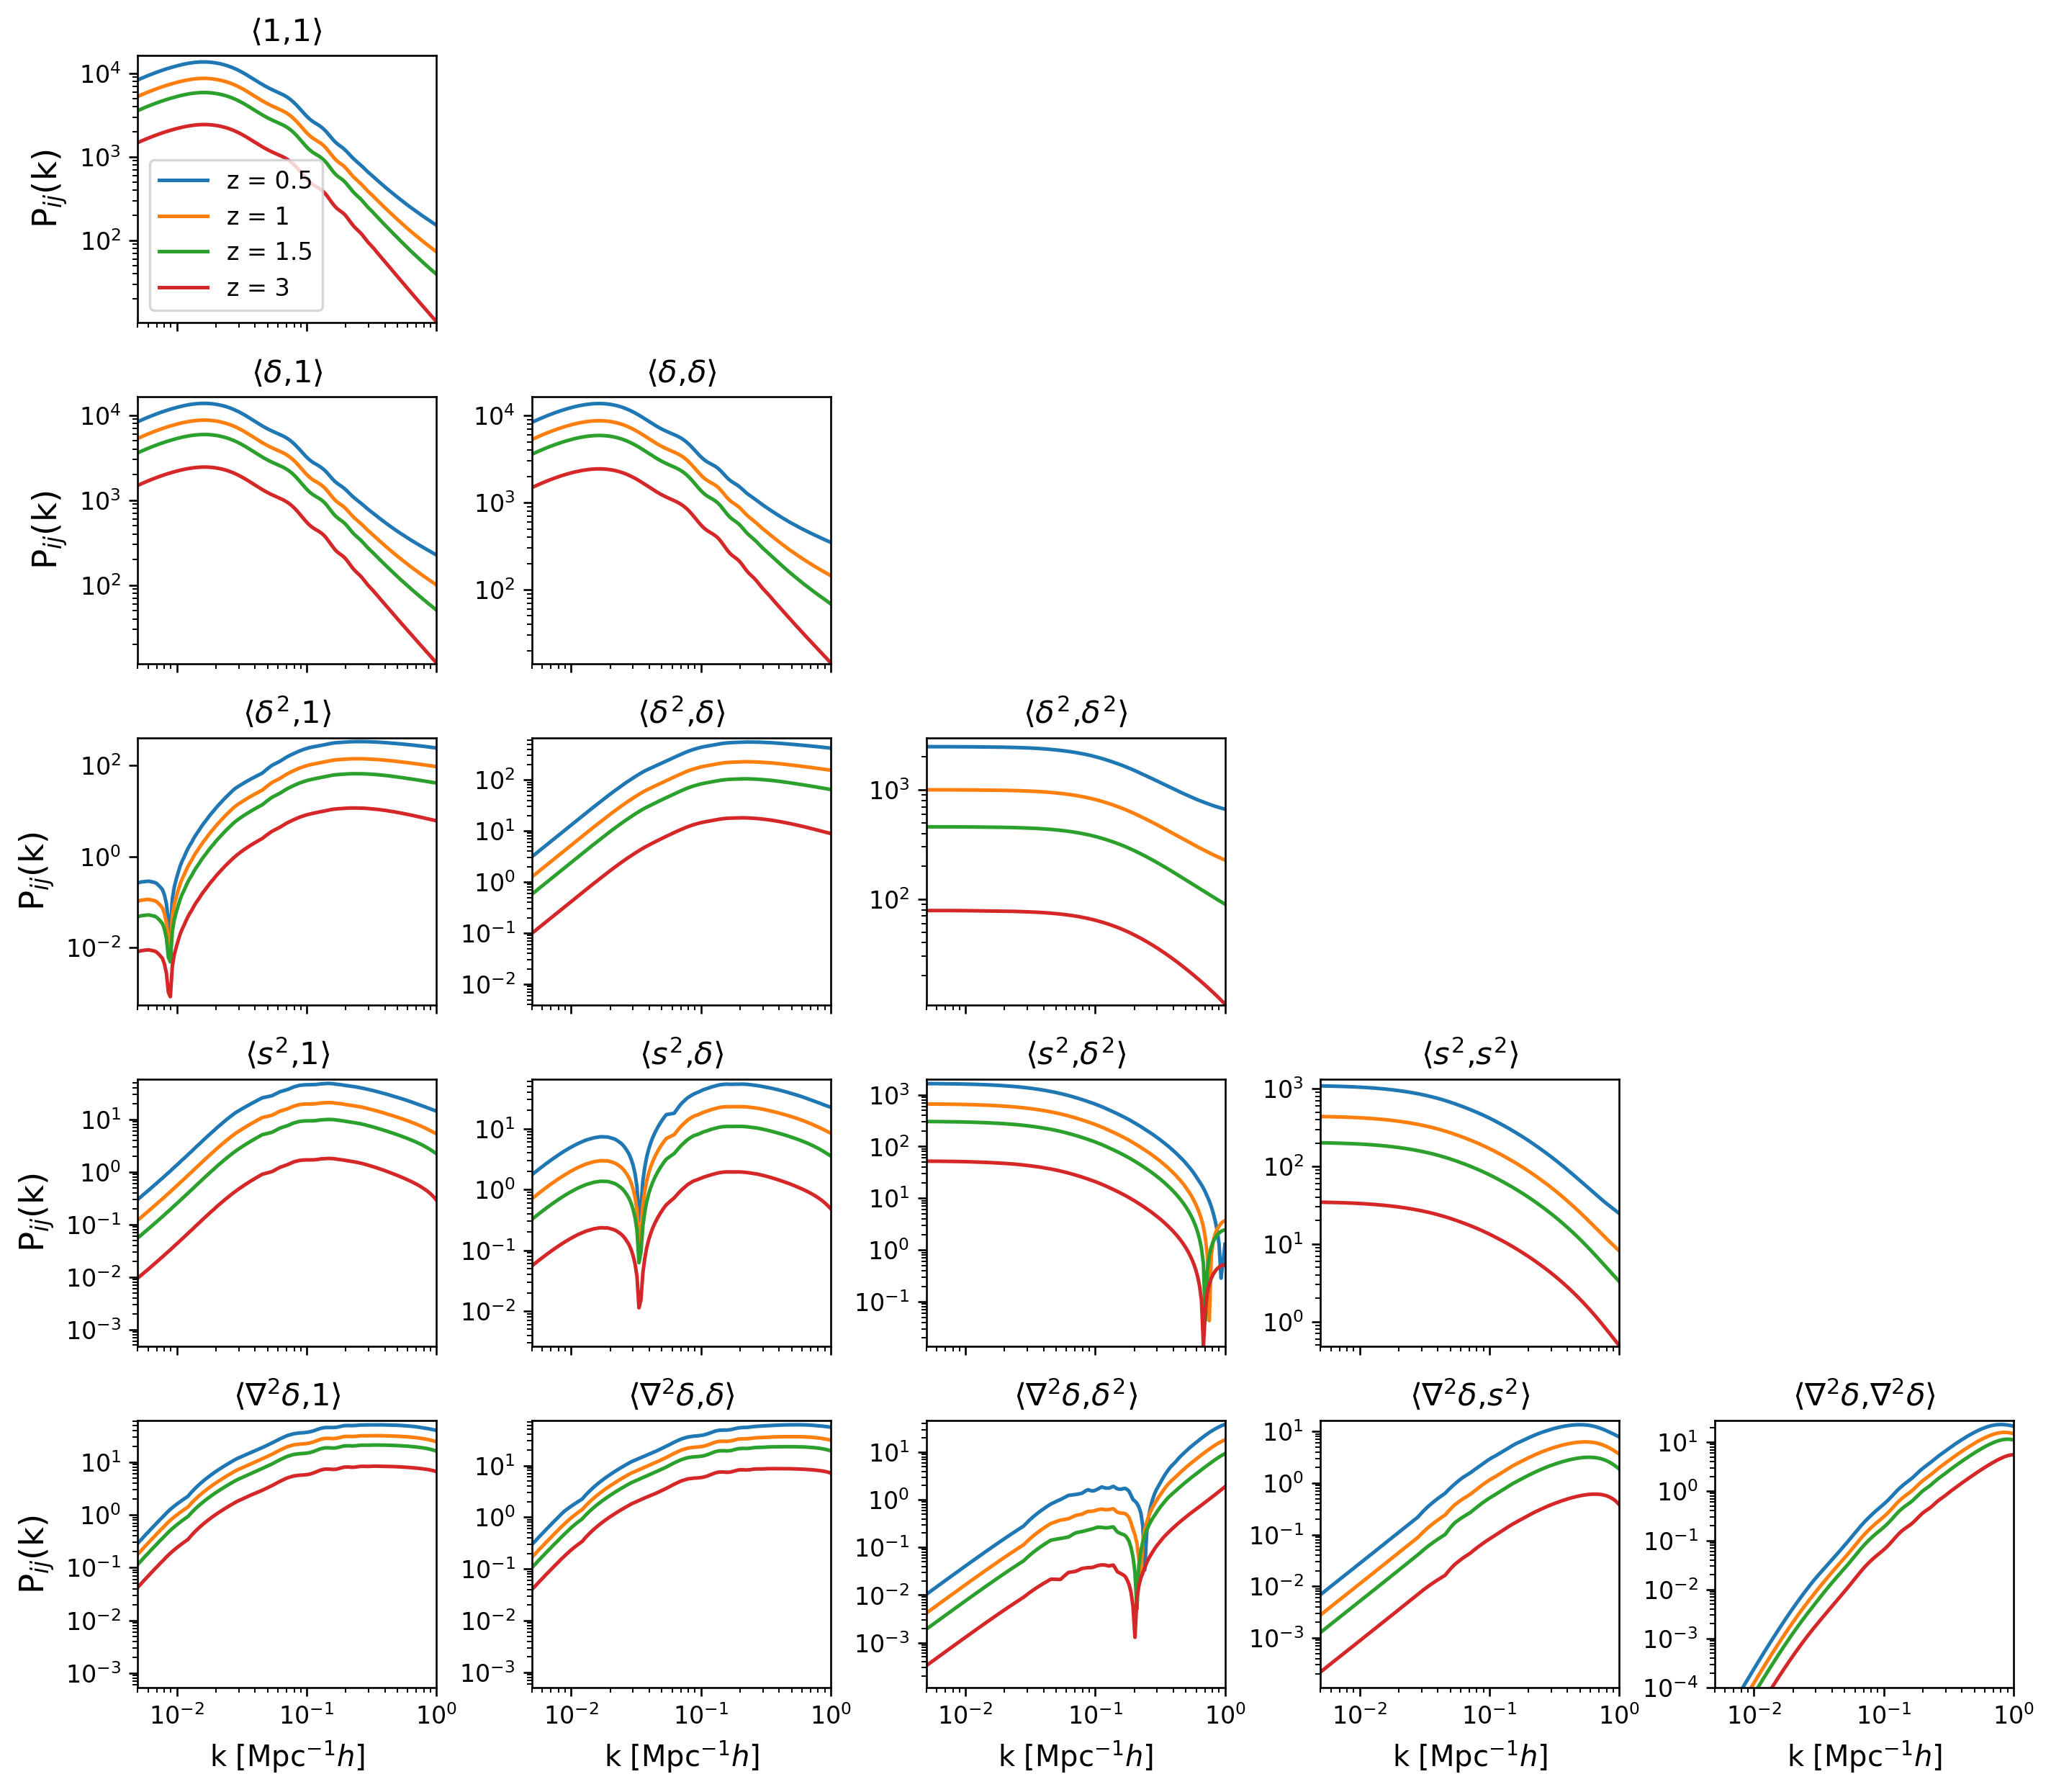

In [8]:
## set the (k, z) bins for the emulator
k = np.logspace(-3, 0, 200)     # unit : [h/Mpc]
z = [0.5, 1, 1.5, 3]
emu.set_k_and_z(k, z)

# [Omega_b, Omega_m, h, n_s, 1e9 A_s, w_0, w_a, M_\nu ]
params = [ 0.048, 0.31, 0.67, 0.9665, 2.105, -0.9, 0.1, 0.03, ]
Pk_ij = emu(params)

labels = [ "1", r"$\delta$", r"$\delta^2$", r"$s^2$", r"$\nabla^2\delta$", r"$\delta^3$", ]
n = 5
fig, axes = plt.subplots(n, n, dpi=120, figsize=(12, 10.5), sharex=True, )
ipk = -1
for j in range(n+1):
    for i in range(n+1):
        if i==n or j==n : ipk+=1; continue
        if i < j: axes[i,j].axis('off') ; continue
        ipk += 1
        for iz in range(4):
            axes[i,j].loglog( k, np.abs(Pk_ij[ipk, iz,]), c=f"C{iz}", label=f"z = {z[iz]}" )
        
        vmin, vmax = np.abs(Pk_ij[ipk]).min(), np.abs(Pk_ij[ipk]).max()
        axes[i,j].set_title( f'⟨{labels[i]},{labels[j]}⟩', fontsize=13)
        axes[i,j].set_xlim( 0.5e-2, 1 )
        axes[i,j].set_ylim( vmin*0.98+1e-4, vmax*1.2 )
for i in range(n):
    axes[-1,i].set_xlabel(r"k [Mpc$^{-1}h$]", fontsize=12, )
    axes[i, 0].set_ylabel("P$_{ij}$(k)", fontsize=14, )
axes[0,0].legend(fontsize=10)
plt.tight_layout( h_pad=0.8, w_pad=0, )
#plt.savefig( "./figures/basis_spectra.png", )
plt.show()

In [9]:
pk_auto, pk_cross = EFTofLSS_Model.CombinePkij( k, Pk_ij, *bias[1:] )
pk_auto += bias[0] *pk_shot

### 